In [ ]:
'''
Panagiotis Christakakis
'''

In [102]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import unique
from sklearn import cluster
from tensorflow import keras
from random import randrange
from keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from sklearn import cluster, metrics
from keras.datasets import fashion_mnist
from sklearn.mixture import GaussianMixture
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation

In [14]:
#define a performance evaluation function
from sklearn import metrics
def performance_score(input_values, cluster_indexes):
    try:
        silh_score = metrics.silhouette_score(input_values.reshape(-1, 1), cluster_indexes)
        print(' .. Silhouette Coefficient score is {:.2f}'.format(silh_score))
        #print( ' ... -1: incorrect, 0: overlapping, +1: highly dense clusts.')
    except:
        print(' .. Warning: could not calculate Silhouette Coefficient score.')
        silh_score = -999

    try:
        ch_score = metrics.calinski_harabasz_score(input_values.reshape(-1, 1), cluster_indexes)
        print(' .. Calinski-Harabasz Index score is {:.2f}'.format(ch_score))
        #print(' ... Higher the value better the clusters.')
    except:
        print(' .. Warning: could not calculate Calinski-Harabasz Index score.')
        ch_score = -999

    try:
        db_score = metrics.davies_bouldin_score(input_values.reshape(-1, 1), cluster_indexes)
        print(' .. Davies-Bouldin Index score is {:.2f}'.format(db_score))
    except:
        print(' .. Warning: could not calculate Davies-Bouldin Index score.')
        db_score = -999

    try:
        adj_mutual_score = metrics.adjusted_mutual_info_score(input_values, cluster_indexes)
        print(' .. Adjusted Mutual Info score is {:.2f}'.format(adj_mutual_score))
    except:
        print(' .. Warning: could not calculate Adjusted Mutual Info score.')
        adj_mutual_score = -999

    return silh_score, ch_score, db_score, adj_mutual_score

In [15]:
#define some parametes related to specific training problem
batch_size = 64
num_classes = 10
epochs = 10

In [16]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [17]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [18]:
# scale pixels
# convert from integers to floats
train_norm = x_train.astype('float32')
test_norm = x_test.astype('float32')
# normalize to range 0-1
x_train = train_norm / 255.0
x_test = test_norm / 255.0

In [19]:
# do not forget the validate set
X_train, X_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [20]:
# Build the autoencoder
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same',activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 14)        140       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 14)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 14)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 7)         889       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 7)          0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 7)           0

In [21]:
#train the model
history = model.fit(X_train, X_train, epochs = 3, batch_size = 64, 
                    validation_data=(X_validate, X_validate), verbose=1)

Epoch 1/3
750/750 [==============================] - 93s 123ms/step - loss: 0.0331 - val_loss: 0.0224
Epoch 2/3
750/750 [==============================] - 91s 121ms/step - loss: 0.0237 - val_loss: 0.0190
Epoch 3/3
750/750 [==============================] - 89s 119ms/step - loss: 0.0218 - val_loss: 0.0178


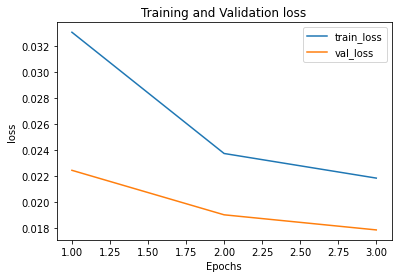

In [22]:
#plot train-val loss & accuracy for epochs
def plot_metric(history, loss):
      train_loss = history.history[loss]
      
      val_loss = history.history['val_'+loss]
      epochs = range(1, len(train_loss) + 1)
      plt.plot(epochs, train_loss)
      plt.plot(epochs, val_loss)
      plt.title('Training and Validation '+ loss)
      plt.xlabel("Epochs")
      plt.ylabel(loss)
      plt.legend(["train_"+loss, 'val_'+loss])
      plt.show()

plot_metric(history, 'loss')

313/313 [==============================] - 6s 20ms/step


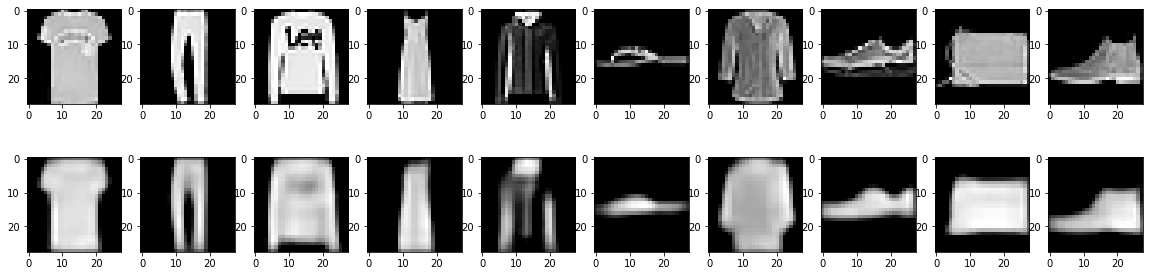

In [23]:
# do some plotting for the reconstructed images
import matplotlib.pyplot as plt
restored_testing_dataset = model.predict(x_test)
# Observe the reconstructed image quality
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

In [25]:
#exctract the encoder block
encoder = K.function([model.layers[0].input],[model.layers[4].output])

In [26]:
#convert images to projected data
test_encoded_images = encoder([x_test])[0].reshape(-1,7*7*7)

In [27]:
#K MEANS CLUSTERING

#use projections to cluster the images
for numOfClust in range (3,12):
  print('Currently testing', str(numOfClust), 'number of clusters')
  mbkm = cluster.MiniBatchKMeans(n_clusters = numOfClust)
  mbkm.fit(test_encoded_images)
  clusterLabels = mbkm.labels_
  silh_score, ch_score, db_score, adj_mutual_score = performance_score(y_test, clusterLabels)

Currently testing 3 number of clusters
 .. Silhouette Coefficient score is 0.08
 .. Calinski-Harabasz Index score is 2579.15
 .. Davies-Bouldin Index score is 2.18
 .. Adjusted Mutual Info score is 0.31
Currently testing 4 number of clusters
 .. Silhouette Coefficient score is 0.04
 .. Calinski-Harabasz Index score is 3139.76
 .. Davies-Bouldin Index score is 4.43
 .. Adjusted Mutual Info score is 0.34
Currently testing 5 number of clusters
 .. Silhouette Coefficient score is -0.01
 .. Calinski-Harabasz Index score is 2373.23
 .. Davies-Bouldin Index score is 6.15
 .. Adjusted Mutual Info score is 0.37
Currently testing 6 number of clusters
 .. Silhouette Coefficient score is -0.05
 .. Calinski-Harabasz Index score is 2412.73
 .. Davies-Bouldin Index score is 11.39
 .. Adjusted Mutual Info score is 0.45
Currently testing 7 number of clusters
 .. Silhouette Coefficient score is -0.10
 .. Calinski-Harabasz Index score is 2044.92
 .. Davies-Bouldin Index score is 20.68
 .. Adjusted Mutual

In [28]:
#use minibatch kmeans with 10 clusters
# Cluster the training set
mbkm = cluster.MiniBatchKMeans(n_clusters = 3)
mbkm.fit(test_encoded_images)
clusterLabels = mbkm.labels_

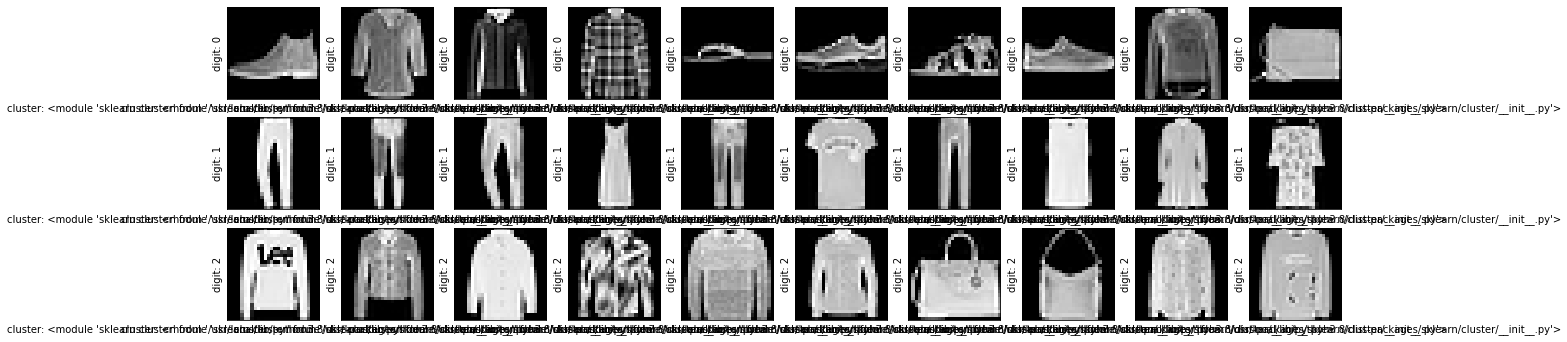

In [29]:
#performance scores & visualizations
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(10):
    # cluster = cm[r].argmax()
    for c, val in enumerate(x_test[clusterLabels == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(clusterIdx))

In [103]:
#DBSCAN Clustering
eps_test = 1
while eps_test <= 2:
  for min_samples_test in range(1,10):
    print('Currently testing for eps: ', str(eps_test), 'and min_samples: ', str(min_samples_test))
    dbscan = cluster.DBSCAN(eps = eps_test, min_samples = min_samples_test)
    dbscan.fit(test_encoded_images)
    clusterLabels = dbscan.labels_
    clusters = unique(clusterLabels)
    silh_score, ch_score, db_score, adj_mutual_score = performance_score(y_test, clusterLabels)
    print(len(clusters))
  eps_test += 0.5

Currently testing for eps:  1 and min_samples:  1
 .. Silhouette Coefficient score is -0.88
 .. Calinski-Harabasz Index score is 1.21
 .. Davies-Bouldin Index score is 3.44
 .. Adjusted Mutual Info score is 0.01
1205
Currently testing for eps:  1 and min_samples:  2
 .. Silhouette Coefficient score is -0.94
 .. Calinski-Harabasz Index score is 5.27
 .. Davies-Bouldin Index score is 4.60
 .. Adjusted Mutual Info score is 0.03
57
Currently testing for eps:  1 and min_samples:  3
 .. Silhouette Coefficient score is -0.79
 .. Calinski-Harabasz Index score is 13.59
 .. Davies-Bouldin Index score is 5.32
 .. Adjusted Mutual Info score is 0.03
16
Currently testing for eps:  1 and min_samples:  4
 .. Silhouette Coefficient score is -0.50
 .. Calinski-Harabasz Index score is 24.09
 .. Davies-Bouldin Index score is 4.62
 .. Adjusted Mutual Info score is 0.03
10
Currently testing for eps:  1 and min_samples:  5
 .. Silhouette Coefficient score is -0.21
 .. Calinski-Harabasz Index score is 51.22
 

In [104]:
#use dbscan with best parameter
# Cluster the training set
dbscan = cluster.DBSCAN(eps = 1, min_samples = 9)
dbscan.fit(test_encoded_images)
clusterLabels = dbscan.labels_
silh_score, ch_score, db_score, adj_mutual_score = performance_score(y_test, clusterLabels)

 .. Silhouette Coefficient score is -0.18
 .. Calinski-Harabasz Index score is 124.23
 .. Davies-Bouldin Index score is 3.05
 .. Adjusted Mutual Info score is 0.04


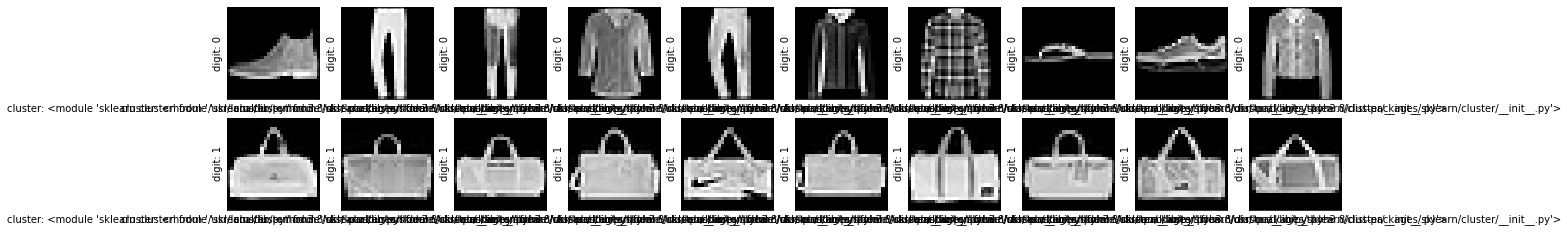

In [105]:
#performance scores & visualizations
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(10):
    # cluster = cm[r].argmax()
    for c, val in enumerate(x_test[clusterLabels == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(clusterIdx))

In [110]:
#OPTICS Clustering
eps_test = 0.5
while eps_test <= 2:
  for min_samples_test in range(1,8):
    print('Currently testing for eps: ', str(eps_test), 'and min_samples: ', str(min_samples_test))
    optics = cluster.OPTICS(eps = eps_test, min_samples = min_samples_test)
    optics.fit(test_encoded_images)
    clusterLabels = optics.labels_
    clusters = unique(clusterLabels)
    silh_score, ch_score, db_score, adj_mutual_score = performance_score(y_test, clusterLabels)
    print(len(clusters))
  eps_test += 0.5

Currently testing for eps:  0.5 and min_samples:  1
 .. Warning: could not calculate Silhouette Coefficient score.
 .. Warning: could not calculate Calinski-Harabasz Index score.
 .. Warning: could not calculate Davies-Bouldin Index score.
 .. Adjusted Mutual Info score is 0.00
1
Currently testing for eps:  0.5 and min_samples:  2
 .. Silhouette Coefficient score is -0.80
 .. Calinski-Harabasz Index score is 2.89
 .. Davies-Bouldin Index score is 6.12
 .. Adjusted Mutual Info score is 0.09
979
Currently testing for eps:  0.5 and min_samples:  3
 .. Silhouette Coefficient score is -0.93
 .. Calinski-Harabasz Index score is 4.45
 .. Davies-Bouldin Index score is 8.84
 .. Adjusted Mutual Info score is 0.07
225
Currently testing for eps:  0.5 and min_samples:  4
 .. Silhouette Coefficient score is -0.97
 .. Calinski-Harabasz Index score is 5.74
 .. Davies-Bouldin Index score is 9.88
 .. Adjusted Mutual Info score is 0.04
75
Currently testing for eps:  0.5 and min_samples:  5
 .. Silhouette

In [111]:
#use dbscan with best parameter
# Cluster the training set
optics = cluster.OPTICS(eps = 0.5, min_samples = 7)
optics.fit(test_encoded_images)
clusterLabels = optics.labels_
silh_score, ch_score, db_score, adj_mutual_score = performance_score(y_test, clusterLabels)

 .. Silhouette Coefficient score is -0.81
 .. Calinski-Harabasz Index score is 10.07
 .. Davies-Bouldin Index score is 3.76
 .. Adjusted Mutual Info score is 0.01


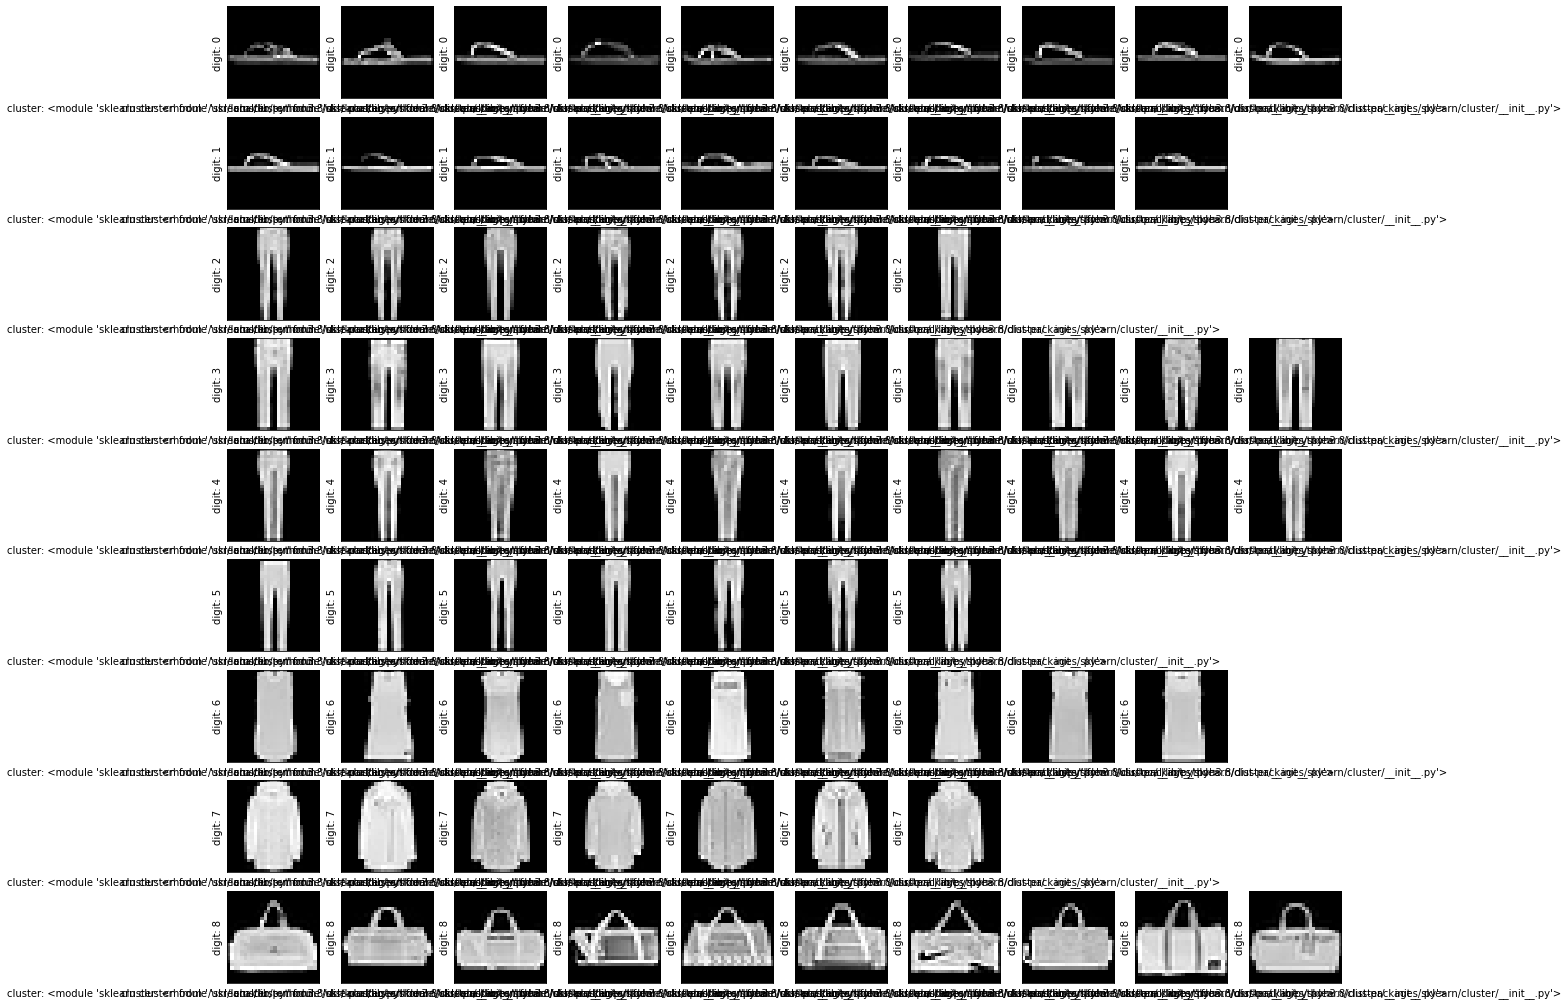

In [112]:
#performance scores & visualizations
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(10):
    # cluster = cm[r].argmax()
    for c, val in enumerate(x_test[clusterLabels == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(clusterIdx))